In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
import torch
import torch.nn as nn

/home/jliudq/miniconda3/envs/rcfda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import load_dataset
dataset = load_dataset("imdb")
print(dataset)
imdb_test = dataset['test']
imdb_train = dataset['train']

Found cached dataset imdb (/home/zmengaf/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|██████████| 3/3 [00:00<00:00, 127.68it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
checkpoint_path = "/home/zmengaf/5212/RCFDA/bert_model_arxiv_acc_0.8027633851468048.pt"
model = torch.load(checkpoint_path)
model.classifier = nn.Linear(model.config.hidden_size, 2)

In [4]:
from peft import LoraConfig, TaskType

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=8, lora_alpha=16, lora_dropout=0.05
)

In [5]:
from peft import get_peft_model
model = get_peft_model(model, lora_config)
model.num_labels = 2

In [6]:
print(model.num_labels)

2


In [7]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

total_params, trainable_params = count_parameters(model)
trainable_percentage = trainable_params / total_params * 100

print(f"trainable params: {trainable_params} || all params: {total_params} || trainable%: {trainable_percentage:.10f}")

trainable params: 296450 || all params: 109780228 || trainable%: 0.2700395193


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)

/home/jliudq/miniconda3/envs/rcfda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [9]:
imdb_train_encodings = tokenizer(list(imdb_train['text']), truncation=True, padding=True,max_length=512)
imdb_train_labels = torch.tensor(list(imdb_train['label']))
imdb_train_dataset = TensorDataset(torch.tensor(imdb_train_encodings['input_ids']),
                                  torch.tensor(imdb_train_encodings['attention_mask']),
                                  imdb_train_labels)
imdb_train_loader = DataLoader(imdb_train_dataset, batch_size=16, shuffle=True)

imdb_test_encodings = tokenizer(list(imdb_test['text']), truncation=True, padding=True,max_length=512)
imdb_test_labels = torch.tensor(list(imdb_test['label']))
imdb_test_dataset = TensorDataset(torch.tensor(imdb_test_encodings['input_ids']),
                                  torch.tensor(imdb_test_encodings['attention_mask']),
                                  imdb_test_labels)
imdb_test_loader = DataLoader(imdb_test_dataset, batch_size=16, shuffle=False)

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(10):
    model.train()
    train_loss = 0
    train_correct = 0
    for batch in imdb_train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        train_loss += loss.item()
        train_correct += (logits.argmax(dim=1) == labels).float().sum().item()
        loss.backward()
        optimizer.step()
    train_loss /= len(imdb_train_loader)
    train_accuracy = train_correct / len(imdb_train)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    with torch.no_grad():
        test_correct = 0
        for batch in imdb_test_loader:
            input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            test_correct += (logits.argmax(dim=1) == labels).float().sum().item()
        test_accuracy = test_correct / len(imdb_test)
        test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch + 1}: train_loss={train_loss:.4f}, train_accuracy={train_accuracy:.4f}, test_accuracy={test_accuracy:.4f}")

Epoch 1: train_loss=0.5846, train_accuracy=0.6718, test_accuracy=0.8557
Epoch 2: train_loss=0.3194, train_accuracy=0.8720, test_accuracy=0.8907
Epoch 3: train_loss=0.2825, train_accuracy=0.8874, test_accuracy=0.9009
Epoch 4: train_loss=0.2608, train_accuracy=0.8970, test_accuracy=0.9067
Epoch 5: train_loss=0.2473, train_accuracy=0.9037, test_accuracy=0.9096
Epoch 6: train_loss=0.2383, train_accuracy=0.9047, test_accuracy=0.9121
Epoch 7: train_loss=0.2326, train_accuracy=0.9080, test_accuracy=0.9142
Epoch 8: train_loss=0.2258, train_accuracy=0.9107, test_accuracy=0.9180
Epoch 9: train_loss=0.2194, train_accuracy=0.9150, test_accuracy=0.9200
Epoch 10: train_loss=0.2148, train_accuracy=0.9142, test_accuracy=0.9209


In [10]:
torch.save(model, "lora_bert_model_imdb.pt")

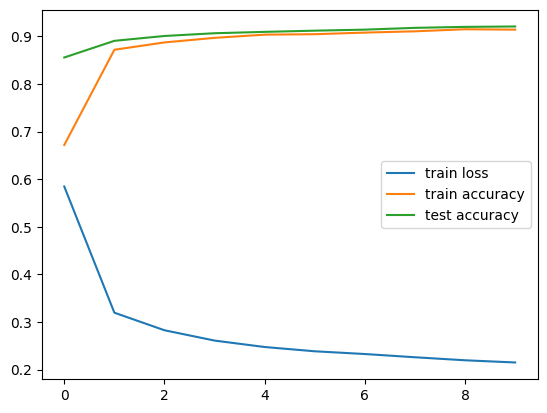

In [12]:
S
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train loss')
plt.plot(train_accuracies, label='train accuracy')
plt.plot(test_accuracies, label='test accuracy')
plt.legend()
plt.show()